# Using Population Data from epydemix_data for Epidemiological Modeling

In this tutorial, we will explore how to use population data from the epydemix_data package to model the spread of diseases. We'll take a practical approach by demonstrating how to load population data, integrate it with an epidemiological model, and run simulations using the ***epydemix*** package.

Let's start importing the necessary libraries:



In [1]:
from epydemix.model import EpiModel
from epydemix.population import Population, load_epydemix_population
from epydemix.visualization import plot_contact_matrix, plot_population, plot_quantiles
import matplotlib.pyplot as plt

## Working with Population Objects

By default, when an ```EpiModel``` instance is created without specific parameters, ***epydemix*** will create a single population with 100000 individuals homogeneously mixed. If you are interested in running your model on demographic data from a specific geography in the world, you can do so by easily import the data contained in the epydemix_data module. 

**Epydemix** supports real-world population data and synthetic contact matrices for epidemic simulation for more than $400$ regions worldwide. A comprehensive list of supported geographies can be found in the [locations.csv](https://github.com/ngozzi/epydemix-data/blob/main/locations.csv) file, while additional information on population data including sources can be found in the [epydemix_data README](https://github.com/ngozzi/epydemix-data).

The **Epydemix** package provides flexibility in loading demographic data and contact matrices for various regions. The `epydemix.model.load_epydemix_population` function allows you to load this data either via **online import** (fetching from a remote source) or **offline import** (loading from a local directory).

- **Online Import**: If `path_to_data` is not provided, **Epydemix** will attempt to import the data directly from GitHub.
- **Offline Import**: If `path_to_data` is provided, **Epydemix** will attempt to load the data from a local directory. For this option, users must first download the corresponding data folder.

Let's see a practical example, importing data for Kenya:

In [2]:
# Load the population of Kenya from GitHub. For offline use, download the population data from
# https://github.com/ngozzi/epydemix_data and provide the local path to 
# the epydemix_data folder using the argument path_to_data
population = load_epydemix_population("Kenya")
print(population)

Population(name='Kenya')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 7066801 individuals
  - 5-19: 20106945 individuals
  - 20-49: 22824354 individuals
  - 50-64: 4243230 individuals
  - 65+: 1643164 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



We see that the ```Population``` object has the following key attributes:

- Population Distribution: this represents the number of individuals in each demographic group (e.g., age groups). By default, population are imported divided into 5 age groups (0-4, 5-19, 20-49, 50-64, 65+) but the granularity can be changed by specifying the ```age_group_mapping``` argument.

- Contact Matrices: these represent contact rates in different contexts (e.g., school, home). More in detail, each element $i, j$ of the contact matrix represents the average rate of contact between two demographic groups.


We can explore population distribution and contact matrices using the ***epydemix*** visualization module:

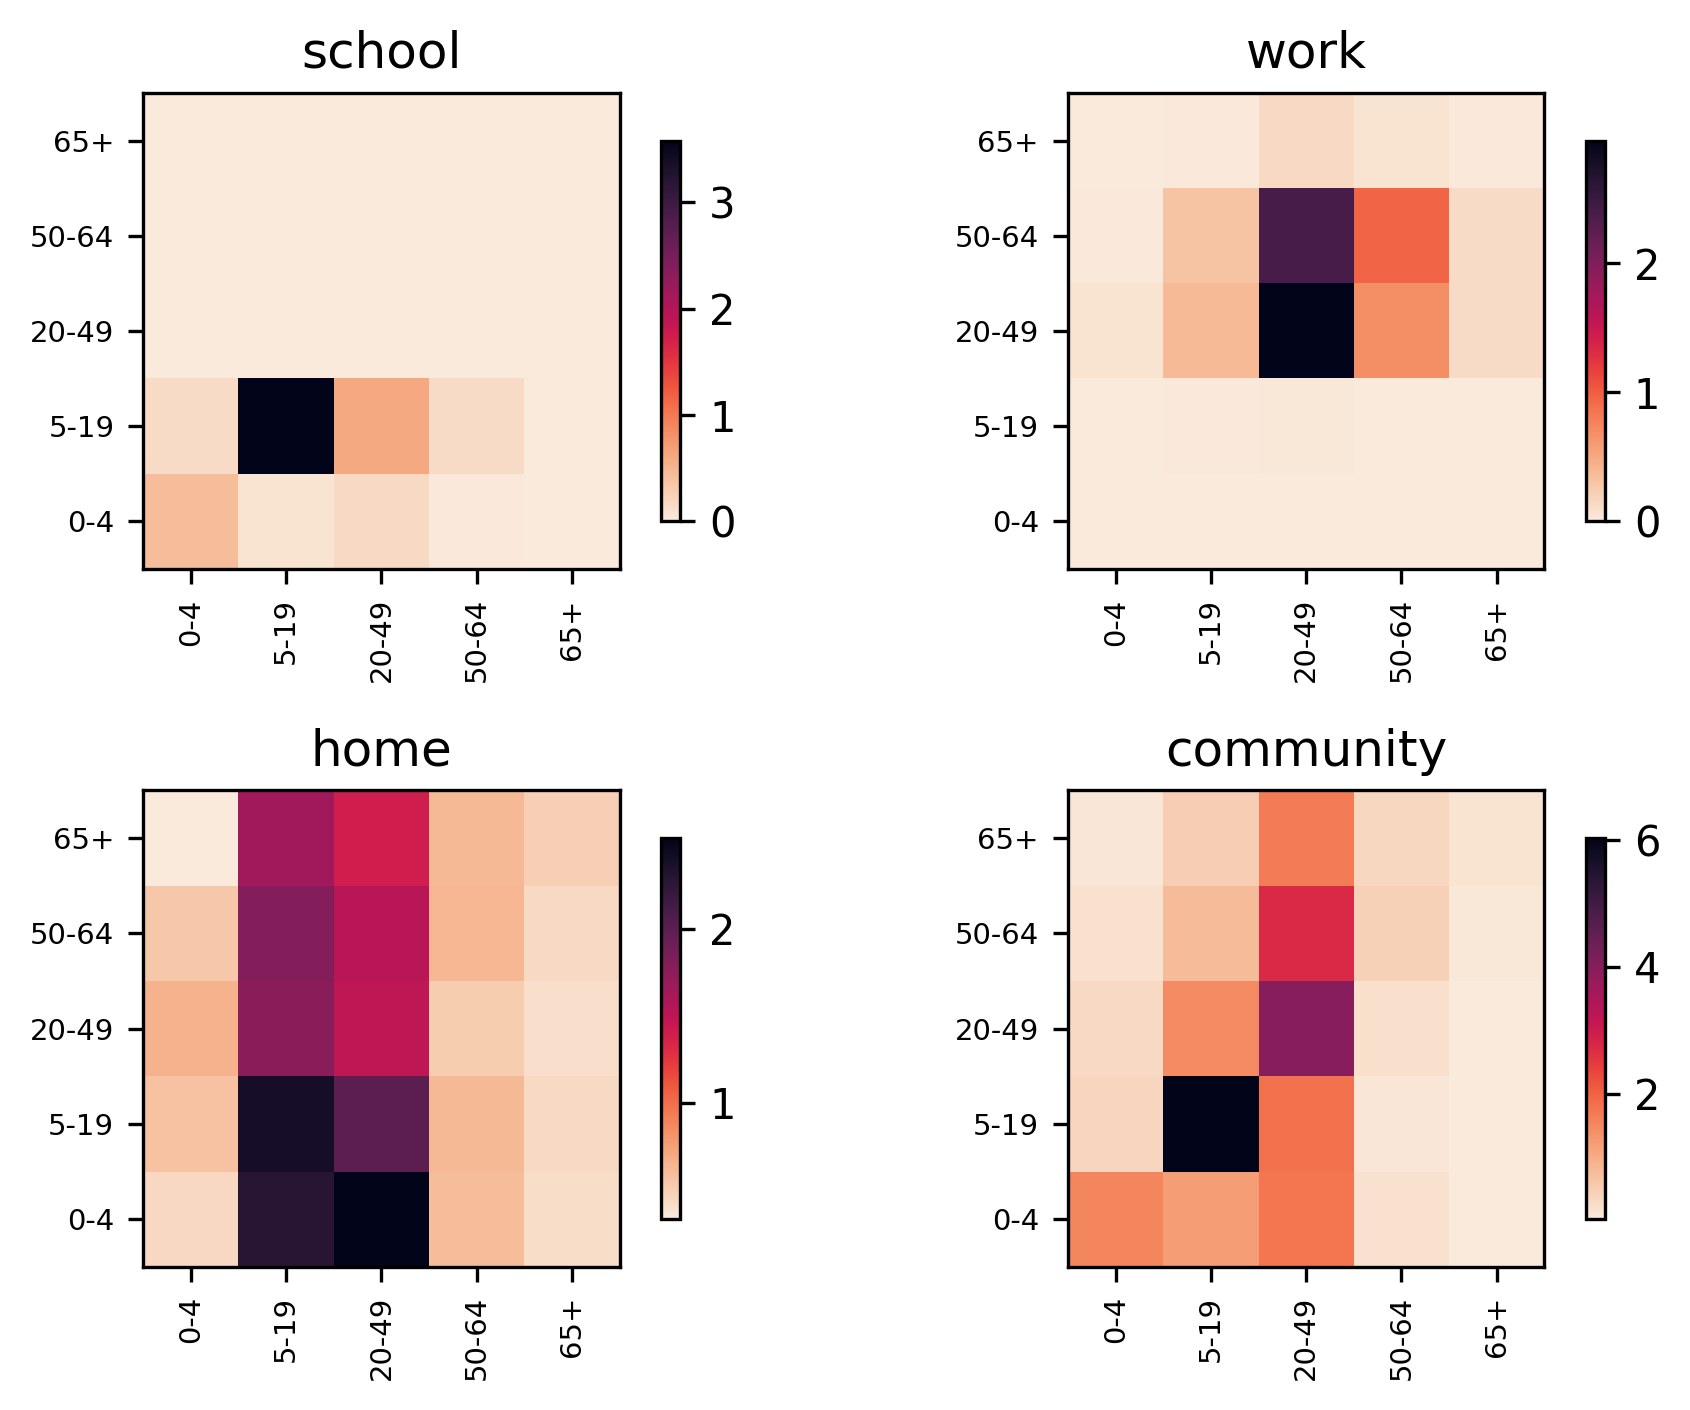

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=300)
plot_contact_matrix(population, "school", ax=axes[0,0], labelsize=7)
plot_contact_matrix(population, "work", ax=axes[0,1], labelsize=7)
plot_contact_matrix(population, "home", ax=axes[1,0], labelsize=7)
plot_contact_matrix(population, "community", ax=axes[1,1], labelsize=7)
plt.tight_layout()

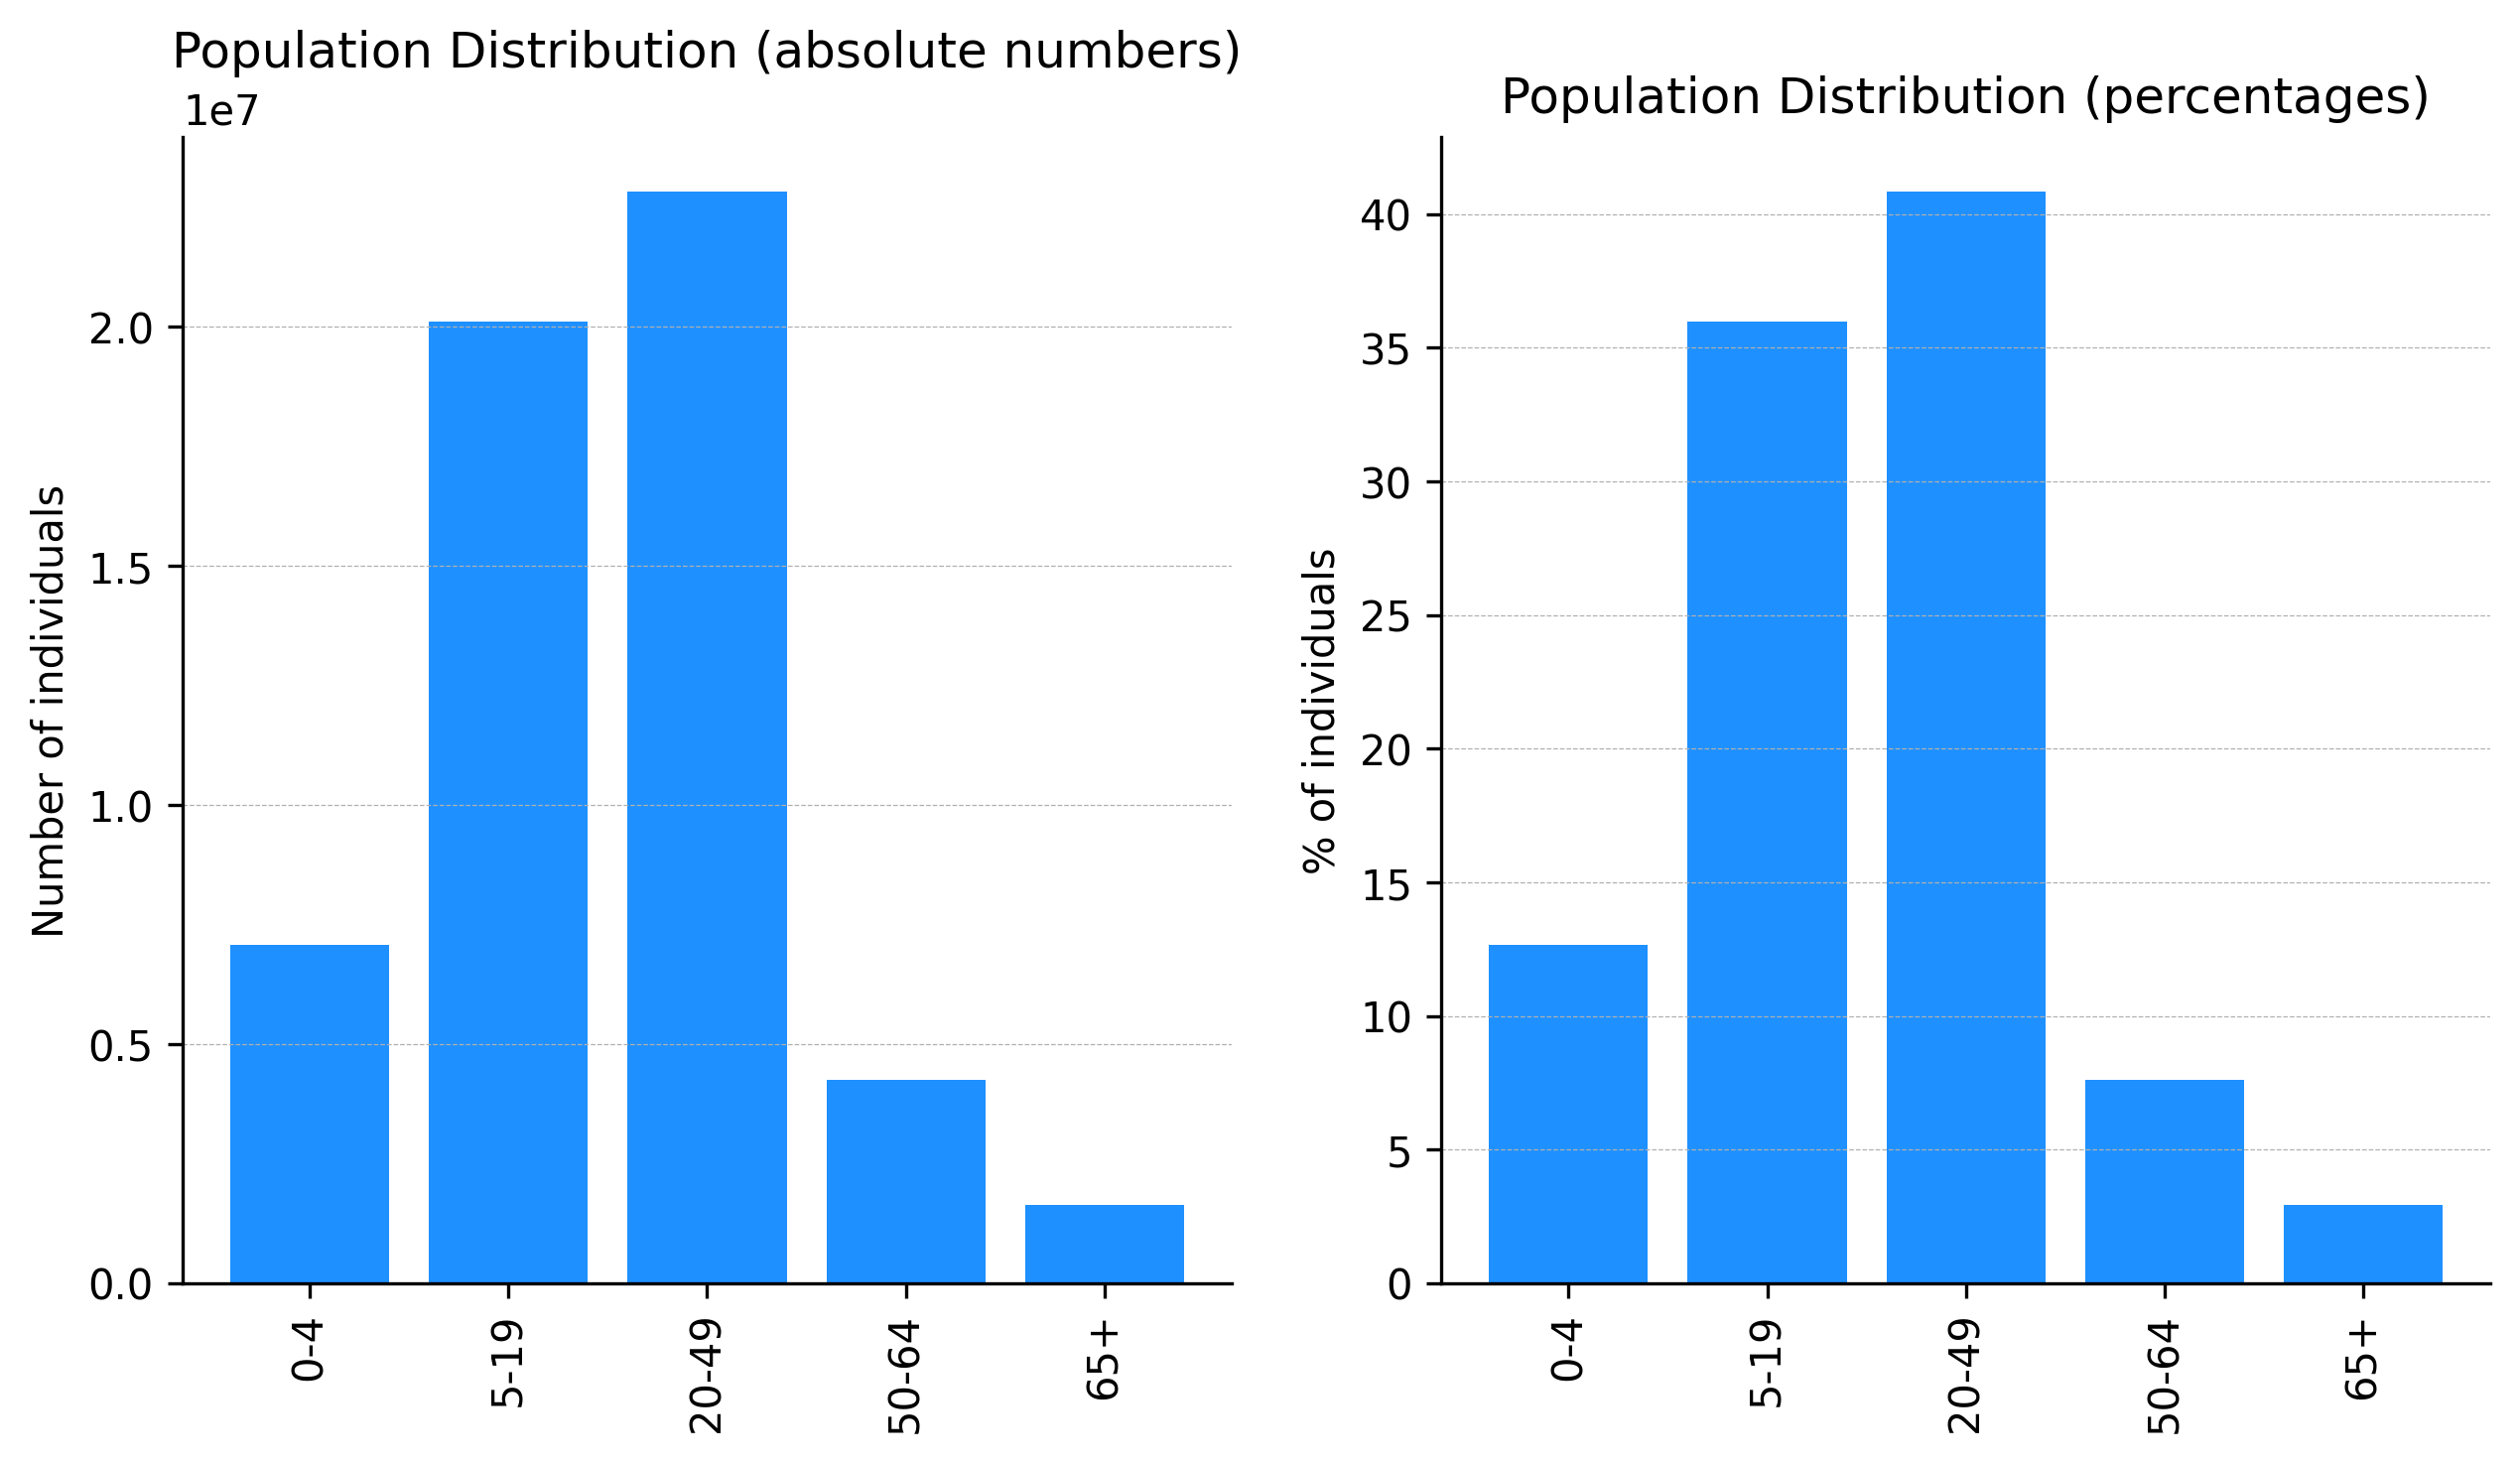

In [4]:
fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(10, 5))
plot_population(population, ax=axes[0], title="Population Distribution (absolute numbers)")
plot_population(population, ax=axes[1], title="Population Distribution (percentages)", show_perc=True)

Alternatively, you can create your own population using your data:

In [5]:
my_population = Population(name="My Population")    
my_population.add_population(Nk=[100, 100], Nk_names=["A", "B"])
my_population.add_contact_matrix(contact_matrix=[[0.2, 0.3], [0.3, 0.2]], layer_name="all")

print(my_population)

Population(name='My Population')
Demographic groups: 2 groups
Population distribution:
  - A: 100 individuals
  - B: 100 individuals
Contact matrices: 1 layers
Available layers:
  - all



## Simulating Epidemic Models on Real-World Populations

Now that we have imported or created our Population object, we can simulate an epidemic model considering this population instead of the default one.

In [6]:
# create a simple SIR model
model = EpiModel(predefined_model="SIR", transmission_rate=0.04)

# set the population (alternatively you can import it using model.import_epydemix_population('Kenya'))    
model.set_population(population)

print(model)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, rate: transmission_rate
    Infected -> Recovered, rate: recovery_rate
Parameters: 2
  Model parameters:
    transmission_rate: 0.04
    recovery_rate: 0.1
Population: Kenya
  Population size: 55884494 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



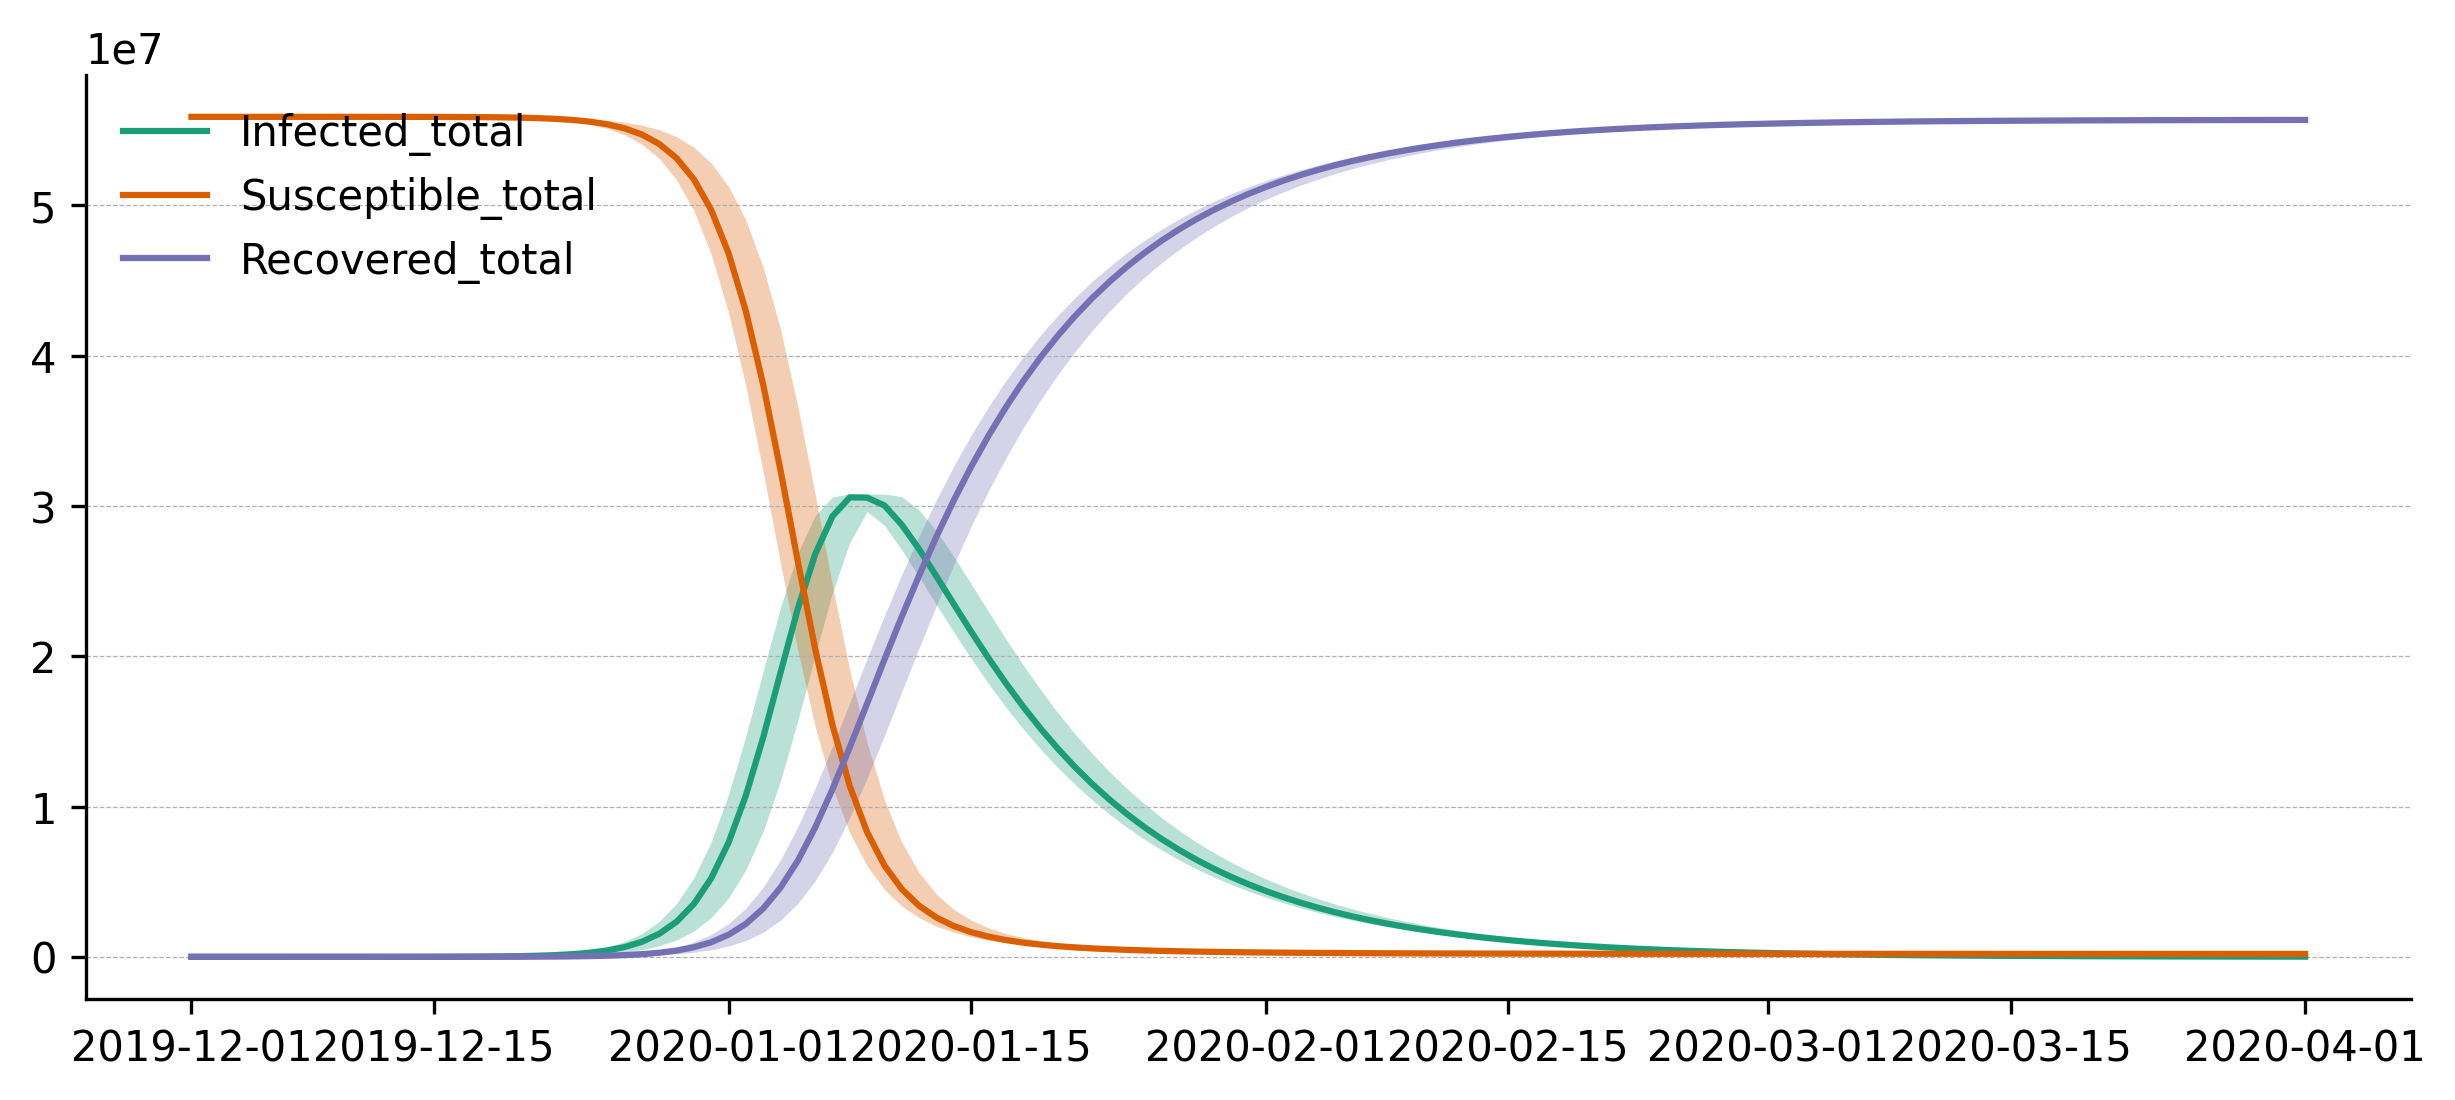

In [7]:
# simulate 
results = model.run_simulations(start_date="2019-12-01", 
                                end_date="2020-04-01", 
                                percentage_in_agents=10 / model.population.Nk.sum(),
                                Nsim=100)

# plot results
plot_quantiles(results, columns=["Infected_total", "Susceptible_total", "Recovered_total"])

We can also inspect the evolution of compartments in specific age groups:

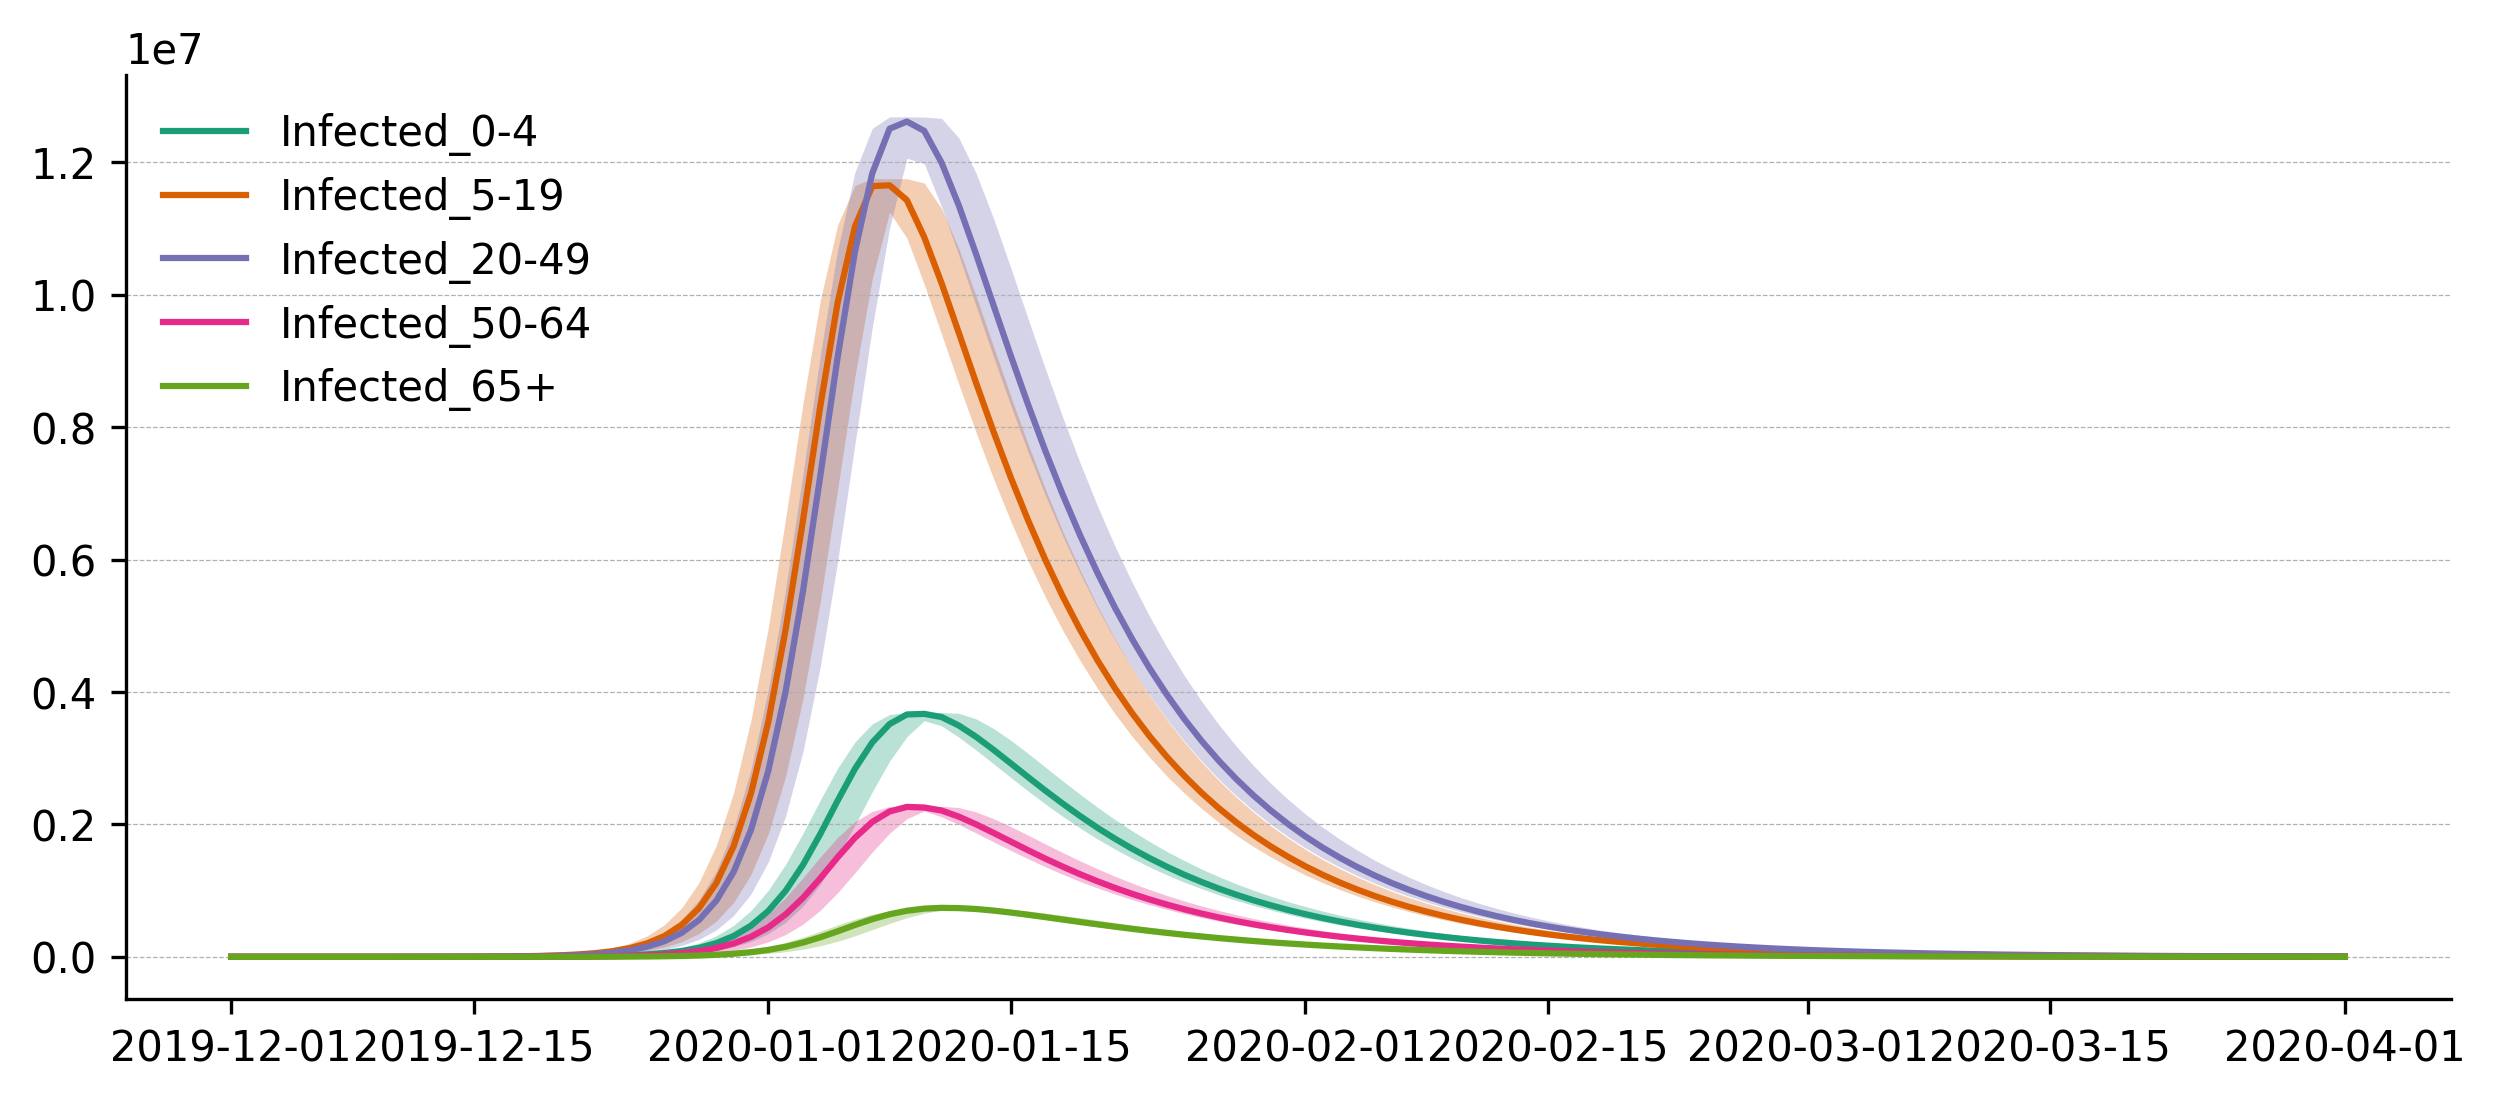

In [8]:
plot_quantiles(results, columns=["Infected_0-4", "Infected_5-19", "Infected_20-49", "Infected_50-64", "Infected_65+"])

### Setting a Different Age Group Granularity

As detailed above, by default population are imported divided into 5 age groups (0-4, 5-19, 20-49, 50-64, 65+) but the granularity can be changed by specifying the ```age_group_mapping``` argument.

It is important to note that the maximum granularity depends on the contact matrix source considered, more in detail: 

- Mistry 2021 matrices have a maximum granularity of 85 age groups, ranging 0, 1, ..., 83, 84+
- Prem 2017 and Prem 2021 have a maximum granularity of 16 age groups, ranging 0-4, 5-9, ..., 70-74, 75+

Let's see an example where we import a population setting a different age group mapping:

In [14]:
population = load_epydemix_population("Kenya", 
                                      age_group_mapping={"0-9": ["0-4", "5-9"],
                                                         "10-19": ["10-14", "15-19"],
                                                         "20-29": ["20-24", "25-29"],
                                                         "30-39": ["30-34", "35-39"],
                                                         "40-49": ["40-44", "45-49"],
                                                         "50-59": ["50-54", "55-59"],
                                                         "60-69": ["60-64", "65-69"],
                                                         "70+": ["70-74", "75+"]},
                                      contacts_source="prem_2021")

print(population)

Population(name='Kenya')
Demographic groups: 8 groups
Population distribution:
  - 0-9: 13884227 individuals
  - 10-19: 13289519 individuals
  - 20-29: 10089645 individuals
  - 30-39: 7595060 individuals
  - 40-49: 5139649 individuals
  - 50-59: 3223744 individuals
  - 60-69: 1694316 individuals
  - 70+: 968334 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community

